# ***모듈 및 파일 인스톨***

In [ ]:
#기본적인 모듈을 인스톨합니다.
import pandas as pd
import numpy as np
import seaborn as sns
import io
from sklearn.model_selection import train_test_split
from google.colab import files
import matplotlib.pyplot as plt
import gensim
import html
import re
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from gensim.models import word2vec
from sklearn.manifold import TSNE
import matplotlib as mpl
import matplotlib.pyplot as plt
import gensim 
import gensim.models as g

In [ ]:
#파일을 불러옵니다.
myfile = files.upload()
final_data = pd.read_excel(io.BytesIO(myfile['coment.xlsx']))

Saving coment.xlsx to coment.xlsx


# ***전처리***

> 함수들은 하이퍼링크, 이모지, 아스키문자, 태그를 지워주는 함수들이다.

In [ ]:
def cleanhtml(raw_html):
  cleanr = re.compile('<a.*?>.*?</a>')
  cleantext = re.sub(cleanr, '', raw_html)
  return cleantext

def rmEmoji(inputData):
    return inputData.encode('utf-8', 'ignore').decode('utf-8')

def rmEmoji_ascii(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')

def remove_tag(content):
   cleanr =re.compile('<.*?>')
   cleantext = re.sub(cleanr, '', content)
   return cleantext

> 먼저 코멘트의 하이퍼링크와 html형식을 지워줍니다.

In [ ]:
comment_list = list()
for comment in final_data['comment']:
    de_comments = cleanhtml(str(comment))
    de_comments = html.unescape(de_comments)
    comment_list.append(de_comments)

comment_1 = pd.DataFrame(comment_list)
comment_1.columns = ['comment']
rm = final_data.drop("comment",axis=1)
dataset = pd.concat([comment_1,rm],axis=1)

> 코멘트들의 리코멘트를 잡아내기 위한 전처리

In [ ]:
id_list = final_data['author']
id_list.drop_duplicates(inplace=True)
idls = list()
for ids in id_list:
  idls.append('@'+str(ids))

reply_list = list()
for index,row in dataset.iterrows():
  if '@' in str(row['comment']):
    reply_list.append([index,str(row['comment'])])
reply_df = pd.DataFrame(reply_list)
reply_df.columns = ['id','comment']

In [ ]:
reply_cp = reply_df.copy()
for nick in tqdm(idls):
  cnt = 0
  for row in reply_cp['comment']:
    if nick in (str(row)):
      nake = str(row).replace(nick,"")
      reply_cp['comment'][cnt] = nake
    cnt += 1

  0%|          | 60/189274 [00:00<10:41, 294.92it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
100%|██████████| 189274/189274 [09:11<00:00, 343.36it/s]


In [ ]:
dataset_cp = dataset.copy()
for index,row in reply_cp.iterrows():
  dataset_cp['comment'][row['id']] = row['comment'] 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


> 이후 데이터 중에 @가 코멘트 앞에 있는 경우는 삭제된 저자중에 있다고 판단하여, 삭제하였습니다.

In [ ]:
dataset_cp2 = dataset_cp.drop(list(reply_cp[reply_cp['comment'].str.startswith('@')]['id']))

> 이모지, 아스키, 태그를 지워주고, 결측값을 없앱니다.

In [ ]:
comment_list = list()
for comment in dataset_cp2['comment']:
    de_comments = rmEmoji(str(comment))
    de_comments = rmEmoji_ascii(de_comments)
    de_comments = remove_tag(de_comments)
    comment_list.append(de_comments)

comment_2 = pd.DataFrame(comment_list)
comment_2.columns = ['comment']
rm = dataset_cp2.drop("comment",axis=1)
dataset3 = pd.concat([comment_2,rm],axis=1)
dataset3.dropna(subset=['comment'],inplace =True)

> 워드 단위로 나누는 중 NA값을 삭제 시켜준다.

In [ ]:
Na_list = list()
for index, row in dataset3.iterrows():
  if not text_to_word_sequence(str(row['comment'])):
    Na_list.append(index)

dataset3.drop(index=Na_list, axis=0, inplace=True)
dataset3.reset_index(drop=True, inplace=True)

> 워드 단위로 나누는 중 숫자만 있는 값을 삭제 시켜준다.

In [ ]:
num_list = list()

for index, row in dataset3.iterrows():
  if str(row['comment']).isnumeric():
    num_list.append(index)
  elif  ''.join(text_to_word_sequence(str(row['comment']))).isnumeric():
    num_list.append(index)

dataset3.drop(num_list, inplace=True)
dataset3.reset_index(drop=True, inplace=True)

In [ ]:
dataset_6.shape

(181435, 4)

# ***Word2vec***

> 지금까지 만든 워딩들을 단어 벡터로 바꿔줍니다.

In [ ]:
#파일을 불러옵니다.
myfile = files.upload()
pre_data = pd.read_csv(io.BytesIO(myfile['processing_data.csv']))

Saving processing_data.csv to processing_data.csv


In [ ]:
new_chunck = list()
for sentence in pre_data['comment']:
  url=(" ".join(text_to_word_sequence(str(sentence)))).strip()
  new_chunck.append(url)

In [ ]:
with open('toji.wakati','w',encoding='utf-8') as fp:
    fp.write("\n".join(new_chunck))

data = word2vec.LineSentence('toji.wakati')
model = word2vec.Word2Vec(data,size=200,window=10,hs=1,min_count=2,sg=1) #size=listsize
model.save("toji.model")
print("ok")

# ***PCA t_SNE***

In [ ]:
# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

model_name = 'toji.model'
model = g.Doc2Vec.load(model_name)

vocab = list(model.wv.vocab)
X = model[vocab]
tsne = TSNE(n_components=2)

# 100개의 단어에 대해서만 시각화
X_tsne = tsne.fit_transform(X[:100,:])
# X_tsne = tsne.fit_transform(X)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


25435
[ 0.13724868 -0.05459461 -0.10473468 -0.12978297  0.21259388  0.10863174
  0.05998694  0.05069357 -0.06748327 -0.02811652]


In [ ]:
df = pd.DataFrame(X_tsne, index=vocab[:100], columns=['x', 'y'])

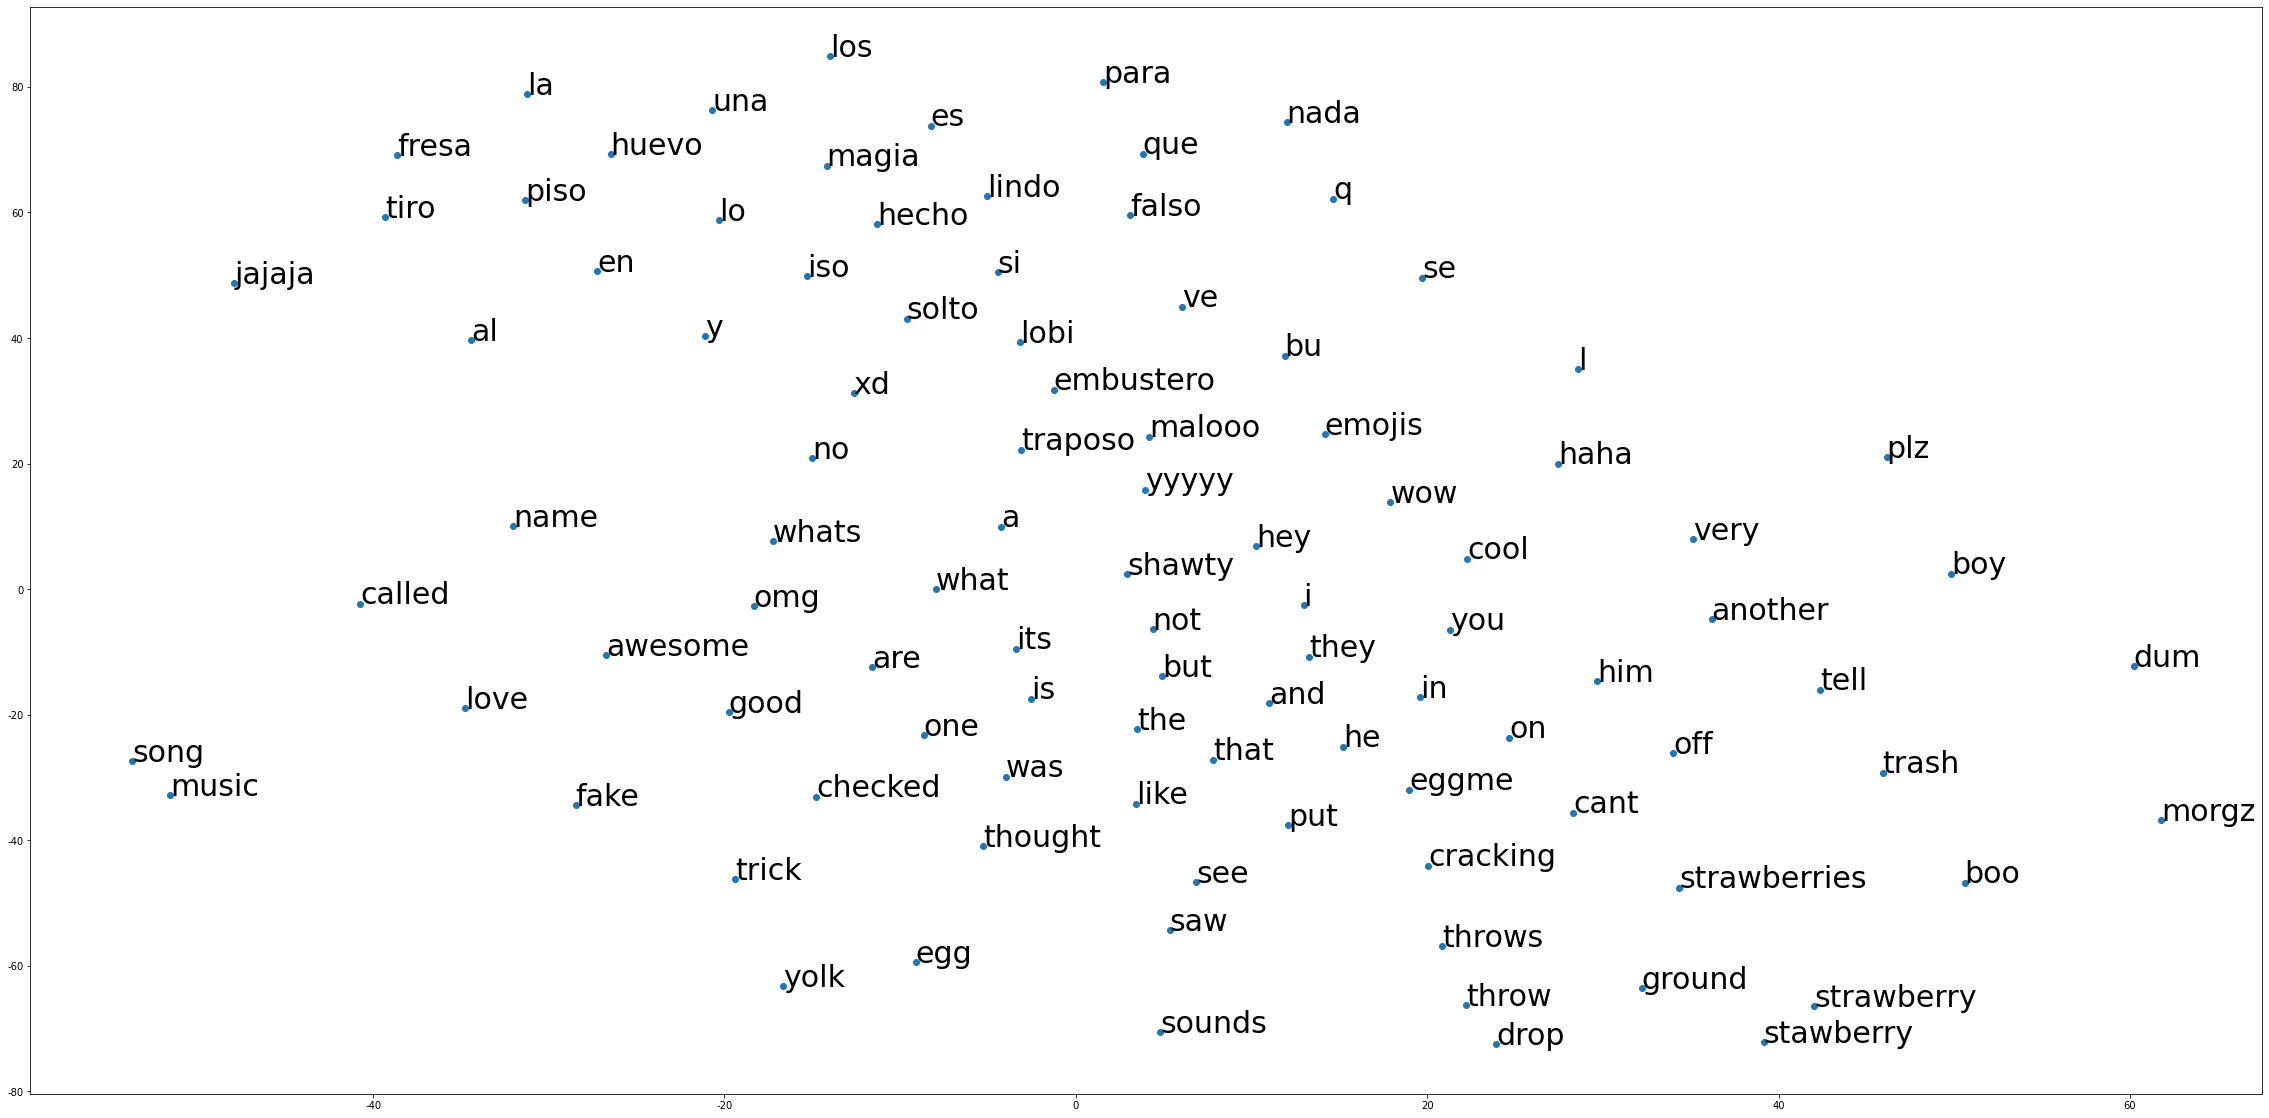

In [ ]:
fig = plt.figure()
fig.set_size_inches(40, 20)
ax = fig.add_subplot(1, 1, 1)

ax.scatter(df['x'], df['y'])

for word, pos in df.iterrows():
    ax.annotate(word, pos, fontsize=30)
plt.show()

In [ ]:
word_vectors = model.wv
vocabs = word_vectors.vocab.keys()
word_vectors_list = [word_vectors[v] for v in vocabs]

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
xys = pca.fit_transform(word_vectors_list)
xs = xys[:,0]
ys=xys[:,1]

In [ ]:
import matplotlib.font_manager as fm
fm._rebuild()

plt.rc('font', family='NanumGothic')

In [ ]:
text=[]
for i,v in enumerate(vocabs):
    text.append(v)
import plotly
import plotly.graph_objects as go
fig = go.Figure(data=go.Scatter(x=xs,
                                y=ys,
                                mode='markers+text',
                                text=text)) 

fig.update_layout(title='Naver Word2Vec')
fig.show()

In [ ]:
plotly.offline.plot(
fig, filename='naver_word2vec.html'
)

'naver_word2vec.html'

# ***단어 긍정 부정***

> 단어의 긍정 목록에 있을 경우 +1 부정에 있을 경우 -1, 중립은 0

In [ ]:
import math

In [ ]:
cd /content/drive/MyDrive/Youtube_spam

/content/drive/MyDrive/Youtube_spam


In [ ]:
postive= list()
f = open("positive-words.txt", "r")
post_box = f.readlines()
f.close()
for i in post_box:
  word = i.strip()
  postive.append(word)

In [ ]:
negative= list()
f = open("negative-words.txt", "r")
nega_box = f.readlines()
f.close()
for i in nega_box:
  word = i.strip()
  negative.append(word)

In [ ]:
pre_data = pd.read_csv('processing_data.csv')

In [ ]:
def word_score(word_box):
  score = 0
  for word in word_box:
    if word in negative:
      score = score -1
    elif word in postive:
      score = score + 1
  return (score / len(word_box)) 

In [ ]:
new_chunck = list()
for sentence in pre_data['comment']:
  word_box=(text_to_word_sequence(str(sentence)))
  score = word_score(word_box)
  new_chunck.append(round(score,3))

In [ ]:
score_df = pd.DataFrame(new_chunck)
score_df.columns = ["score"]

In [ ]:
score_df.head(20)

,score
0,-0.400
1,0.500
2,0.000
3,0.000
4,0.000
5,0.000
6,0.000
7,0.000
8,0.167
9,-0.429


In [ ]:
score_data = pd.concat([pre_data,score_df],axis=1)

In [ ]:
score_data

,comment,author,date,num_likes,score
0,That is fake very fake,Shannon Hopkins,2021-07-19T02:08:08Z,0.0,-0.4
1,wow that is awesome,Rey Conoman,2021-07-19T02:00:23Z,0.0,0.5
2,Sorrry,Dora linda Gutierrez,2021-07-19T01:58:09Z,0.0,0.0
3,Nada l no ISO magia tiro la fresa para l piso ...,Eva Mejia,2021-07-19T01:50:30Z,0.0,0.0
4,HEY YOU CHECKED,Antonia Bryant,2021-07-19T01:44:46Z,0.0,0.0
...,...,...,...,...,...
181430,hills who was first,30cheomu,2021-05-25T05:47:35Z,0.0,0.0
181431,No,MD FARHAN,2021-05-25T05:42:49Z,0.0,0.0
181432,hills yup,30cheomu,2021-05-25T05:31:48Z,0.0,0.0
181433,No,Cuda,2021-05-24T20:25:03Z,0.0,0.0


In [ ]:
score_data.to_csv("score_comment.csv",index = False)